Prepare / Clean Data

In [1]:
# import libraries necessary
import matplotlib.pyplot as plt
import numpy as np

import requests
import sys
import time

from datetime import datetime

# first get data from pdb files and save information locally in appropriate files
with open('cullpdb_pc30_res3.0_R1.0_d191017_chains18877') as infile:
    dataset = infile.readlines()

file_helix = open('pdb_helix_set', 'w')
file_sheet = open('pdb_sheet_set', 'w')
file_atom = open('pdb_atom_set', 'w')

# necessary for progress and time estimate
print("    Processing Data")
i = 1
num_chains = len(dataset)-1
start = time.time()
    
for entry in dataset[1:]:
    pdb_req = entry.strip()[:5]
    pdb_id = pdb_req[:-1]
    pdb_chain = pdb_req[-1:]

    url = 'https://files.rcsb.org/download/{}.pdb'.format(pdb_id)
    
    # if request fails retry until successful
    while True:
        try:
            pdb_file = requests.get(url).text.splitlines()
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except:
            continue
        break
        
    for line in pdb_file:
        record_name = line[:6].strip()
        if record_name == "HELIX" and line[19] == pdb_chain and line[31] == pdb_chain:
            file_helix.write(pdb_req + " " + line[6:] + "\n")
        elif record_name == "SHEET" and line[21] == pdb_chain and line[32] == pdb_chain:
            file_sheet.write(pdb_req + " " + line[6:] + "\n")
        elif record_name == "ATOM" and line[21] == pdb_chain:
            file_atom.write(pdb_req + " " + line[6:] + "\n")
        elif record_name == "HETATM" and line[21] == pdb_chain:
            file_atom.write(pdb_req + " " + line[6:] + "\n")
         
    # display progress bar and time estimate
    end = time.time()
    est = start+((end-start)/i)*num_chains
    est_dt = datetime.fromtimestamp(est)
    est_str = est_dt.strftime('%Y-%m-%d %H:%M:%S')
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-21s] %d%%  %s" % ('='*int(21*(i/num_chains)), int(100*(i/num_chains)), est_str))
    sys.stdout.flush()
    i += 1
            
file_helix.close()
file_sheet.close()
file_atom.close()

    Processing Data
[=====================] 100%  2019-10-25 06:34:46

In [2]:
'''
helix information needed
    pdbIDC            cols 1 -  6    
    serNum            cols 8 - 10
    helixID           cols 12 - 14
    initSeqNum        cols 22 - 25
    endSeqNum         cols 34 - 37
    helixClass        cols 39 - 40
    length            cols 72 - 76
    
sheet information needed
    pdbIDC            cols 1 -  6
    strand            cols 8 - 10
    sheetID           cols 12 - 14
    numStrands        cols 15 - 16
    initSeqNum        cols 23 - 26
    endSeqNum         cols 34 - 37
    
atom information needed
    pdbIDC            cols 1 - 6
    serial            cols 7 - 11
    name              cols 13 - 16
    altLoc            cols 17
    resName           cols 18 - 20
    resSeq            cols 23 - 26
    x                 cols 31 - 38
    y                 cols 39 - 46
    z                 cols 47 - 54  
    
    atom types N CA C for backbone
'''

# process data to keep only these values
file_helix_trimmed = open('pdb_helix_set_trimmed.csv', 'w')
file_helix_trimmed.write("pdbIDC,serNum,helixID,initSeqNum,endSeqNum,helixClass\n")
with open('pdb_helix_set') as infile:
    for line in infile:
        pdbIDC = line[:6].strip()
        serNum = line[7:10].strip()
        helixID = line[11:14].strip()
        initSeqNum = line[21:25].strip()
        endSeqNum = line[33:37].strip()
        helixClass = line[38:40].strip()
        length = line[71:76].strip()
        file_helix_trimmed.write(pdbIDC+","+serNum+","+helixID+","+initSeqNum+","+endSeqNum+","+helixClass+","+length+"\n")
file_helix_trimmed.close()

file_sheet_trimmed = open('pdb_sheet_set_trimmed.csv', 'w')
file_sheet_trimmed.write("pdbIDC,strand,sheetID,numStrands,initSeqNum,endSeqNum\n")
with open('pdb_sheet_set') as infile:
    for line in infile:
        pdbIDC = line[:6].strip()
        strand = line[7:10].strip()
        sheetID = line[11:14].strip()
        numStrands = line[14:16].strip()
        initSeqNum = line[22:26].strip()
        endSeqNum = line[33:37].strip()
        file_sheet_trimmed.write(pdbIDC+","+strand+","+sheetID+","+numStrands+","+initSeqNum+","+endSeqNum+"\n")   
file_sheet_trimmed.close()

file_atom_trimmed = open('pdb_atom_set_trimmed.csv', 'w')
file_atom_trimmed.write("pdbIDC,serial,name,resName,resSeq,x,y,z\n")
with open('pdb_atom_set') as infile:
    for line in infile:
        pdbIDC = line[:6].strip()
        serial = line[6:11].strip()
        name = line[12:16].strip()
        altLoc = line[16]
        resName = line[17:20].strip()
        resSeq = line[22:26].strip()
        x = line[30:38].strip()
        y = line[38:46].strip()
        z = line[46:54].strip()
        if name in ["N","CA","C"]:
            file_atom_trimmed.write(pdbIDC+","+serial+","+name+","+altLoc+","+resName+","+resSeq+","+x+","+y+","+z+"\n")
file_atom_trimmed.close()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

helix_data = np.loadtxt("pdb_helix_set_trimmed.csv", skiprows=1, delimiter=',',
                        dtype = {'names': ('pdbIDC','serNum','helixID','initSeqNum','endSeqNum','helixClass','length'),
                                 'formats': ("U5","i4","U3","i4","i4","i4","i4")})

sheet_data = np.loadtxt("pdb_sheet_set_trimmed.csv", skiprows=1, delimiter=',',
                        dtype = {'names': ('pdbIDC','strand','sheetID','numStrands','initSeqNum','endSeqNum'),
                                 'formats': ("U5","i4","U3","i4","i4","i4")})

atom_data = np.loadtxt("pdb_atom_set_trimmed.csv", skiprows=1, delimiter=',',
                       dtype = {'names': ('pdbIDC','serial','name','altLoc','resName','resSeq','x','y','z'),
                                'formats': ("U5","i4","U4","U1","U3","i4","f8","f8","f8")})

1. Find the popularity of different kind of helices: read the data set and analyze it to find the popularity of each type of helices.

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
                                     CLASS NUMBER
TYPE OF  HELIX                     (COLUMNS 39 - 40)
--------------------------------------------------------------
Right-handed alpha (default)                1
Right-handed omega                          2
Right-handed pi                             3
Right-handed gamma                          4
Right-handed 3 - 10                         5
Left-handed alpha                           6
Left-handed omega                           7
Left-handed gamma                           8
2 - 7 ribbon/helix                          9
Polyproline                                10
'''

helix_tmp = helix_data[np.logical_and(helix_data['helixClass'] > 0, helix_data['helixClass'] < 11)]
helix_types, counts = np.unique(helix_tmp['helixClass'],return_counts=True)

types = ['Right-handed alpha',
         'Right-handed omega',
         'Right-handed pi',
         'Right-handed gamma',
         'Right-handed 3 - 10',
         'Left-handed alpha',
         'Left-handed omega',
         'Left-handed gamma',
         '2 - 7 ribbon/helix',
         'Polyproline']

helix_preference = []
for i in range(0,len(types)):
    helix_preference.append((types[i],0,0.0))
    
for i in range(0,len(helix_types)):
    helix_preference[helix_types[i]-1] = (types[helix_types[i]-1],counts[i],100*counts[i]/np.sum(counts))

helix_pref = np.array(helix_preference,
                      dtype=[('Helix Type', 'U32'), ('Helix Count', 'i4'), ('Helix Percentage', 'f8')])


# print df.to_string(index=False)

df_helix_pref = pd.DataFrame(helix_pref)
df_helix_pref.style.hide_index()

Helix Type,Helix Count,Helix Percentage
Right-handed alpha,131853,73.9576
Right-handed omega,0,0
Right-handed pi,0,0
Right-handed gamma,0,0
Right-handed 3 - 10,46424,26.0396
Left-handed alpha,0,0
Left-handed omega,1,0.000560909
Left-handed gamma,0,0
2 - 7 ribbon/helix,0,0
Polyproline,4,0.00224364


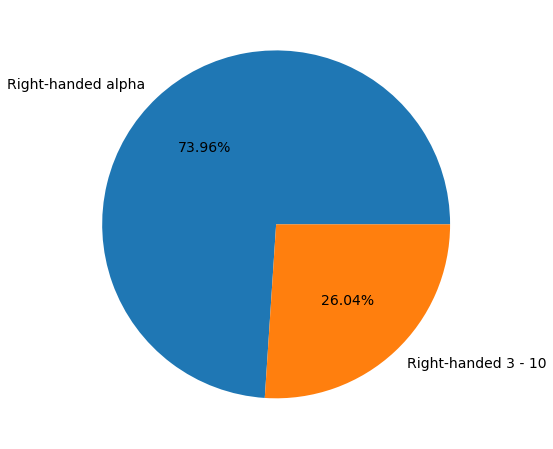

In [60]:
good_data = np.where(counts > 1000)
helix_types = helix_types[good_data]
counts = counts[good_data]

types = ['Right-handed alpha',
         'Right-handed omega',
         'Right-handed pi',
         'Right-handed gamma',
         'Right-handed 3 - 10',
         'Left-handed alpha',
         'Left-handed omega',
         'Left-handed gamma',
         '2 - 7 ribbon/helix',
         'Polyproline']

# change to pie chart

found_types = []
for htype in helix_types:
    found_types.append(types[htype-1])

ind = np.arange(len(helix_types))
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 14
plt.pie(counts,labels=found_types,autopct='%1.2f%%')
plt.show()

2. Analyze the amino acids that prefer to form/be part of helices. Does an AA prefer to form/be part of specific type of helices?

In [2]:
amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = amino_data[np.where(amino_data['name'] == 'N')]

pdbIDC_data = np.unique(helix_data['pdbIDC'])
helix_atoms = None
NoneType = type(helix_atoms)

for pdbIDC in pdbIDC_data:
    tmp_helices = helix_data[np.where(helix_data['pdbIDC'] == pdbIDC)]
    tmp_atoms = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_good_atoms = None
    for helix in tmp_helices:
        good_atoms = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] >= helix['initSeqNum'],tmp_atoms['resSeq']<=helix['endSeqNum'])]
        if type(tmp_good_atoms) == NoneType:
            tmp_good_atoms = good_atoms
        else:
            tmp_good_atoms = np.concatenate((tmp_good_atoms,good_atoms),axis=0)
    tmp, indices = np.unique(tmp_good_atoms['resSeq'],return_index=True)
    tmp_good_atoms = tmp_good_atoms[indices]
    
    if type(helix_atoms) == NoneType:
        helix_atoms = tmp_good_atoms
    else:
        helix_atoms = np.concatenate((helix_atoms,tmp_good_atoms),axis=0)


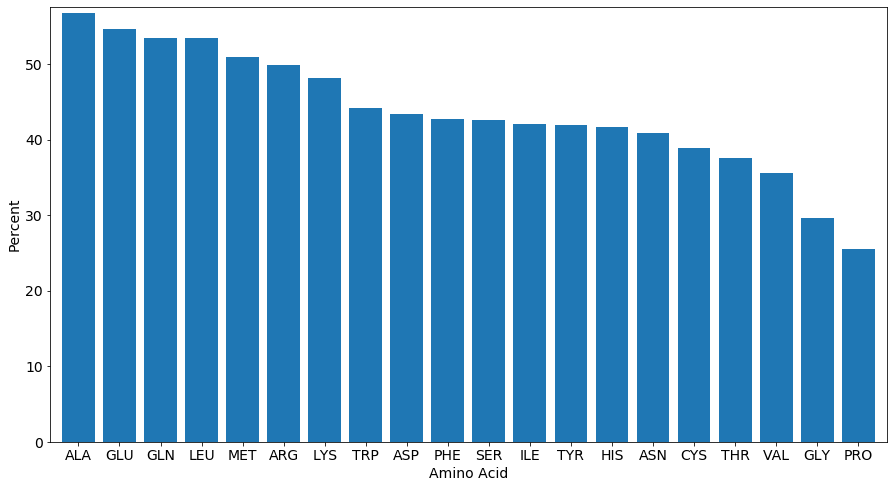

In [17]:
amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

aa_preference = [0] * len(amino_acids)
for i in range(0,len(amino_acids)):
    num = len(helix_atoms[np.where(helix_atoms['resName'] == amino_acids[i])])
    den = len(amino_data[np.where(amino_data['resName'] == amino_acids[i])])
    aa_preference[i] = (amino_acids[i], num, den, num/den)
    

aa_helix_pref = np.array(aa_preference,
                         dtype=[('aa', 'U3'), ('sheetCnt', 'i4'), 
                                ('totalCnt', 'i4'), ('perc', 'f8')])

aa_helix_pref = np.sort(aa_helix_pref,order='perc')
aa_helix_pref = aa_helix_pref[::-1]

ind = np.arange(len(aa_helix_pref))
plt.figure(figsize=(15,8))
plt.bar(ind,aa_helix_pref['perc']*100)
plt.xticks(ind, aa_helix_pref['aa'],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Amino Acid",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.margins(0.015)
plt.show()

In [18]:
amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = amino_data[np.where(amino_data['name'] == 'N')]

pdbIDC_data = np.unique(helix_data['pdbIDC'])
helix_atoms = None
NoneType = type(helix_atoms)

for pdbIDC in pdbIDC_data:
    tmp_helices = helix_data[np.logical_and(helix_data['pdbIDC'] == pdbIDC,helix_data['helixClass'] == 1)]
    tmp_atoms = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_good_atoms = None
    for helix in tmp_helices:
        good_atoms = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] >= helix['initSeqNum'],tmp_atoms['resSeq']<=helix['endSeqNum'])]
        if type(tmp_good_atoms) == NoneType:
            tmp_good_atoms = good_atoms
        else:
            tmp_good_atoms = np.concatenate((tmp_good_atoms,good_atoms),axis=0)
            
    if(type(tmp_good_atoms) != NoneType):
        tmp, indices = np.unique(tmp_good_atoms['resSeq'],return_index=True)
        tmp_good_atoms = tmp_good_atoms[indices]

        if type(helix_atoms) == NoneType:
            helix_atoms = tmp_good_atoms
        else:
            helix_atoms = np.concatenate((helix_atoms,tmp_good_atoms),axis=0)

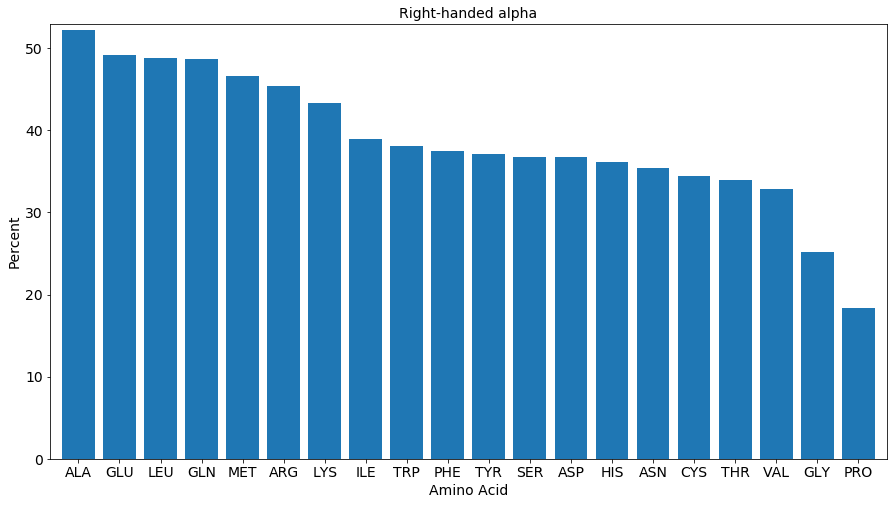

In [19]:
amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

aa_preference = [0] * len(amino_acids)
for i in range(0,len(amino_acids)):
    num = len(helix_atoms[np.where(helix_atoms['resName'] == amino_acids[i])])
    den = len(amino_data[np.where(amino_data['resName'] == amino_acids[i])])
    aa_preference[i] = (amino_acids[i], num, den, num/den)
    

aa_helix_pref = np.array(aa_preference,
                         dtype=[('aa', 'U3'), ('sheetCnt', 'i4'), 
                                ('totalCnt', 'i4'), ('perc', 'f8')])

aa_helix_pref = np.sort(aa_helix_pref,order='perc')
aa_helix_pref = aa_helix_pref[::-1]

ind = np.arange(len(aa_helix_pref))
plt.figure(figsize=(15,8))
plt.bar(ind,aa_helix_pref['perc']*100)
plt.title("Right-handed alpha",fontsize=14)
plt.xticks(ind, aa_helix_pref['aa'],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Amino Acid",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.margins(0.015)
plt.show()

In [20]:
amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = amino_data[np.where(amino_data['name'] == 'N')]

pdbIDC_data = np.unique(helix_data['pdbIDC'])
helix_atoms = None
NoneType = type(helix_atoms)

for pdbIDC in pdbIDC_data:
    tmp_helices = helix_data[np.logical_and(helix_data['pdbIDC'] == pdbIDC,helix_data['helixClass'] == 5)]
    tmp_atoms = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_good_atoms = None
    for helix in tmp_helices:
        good_atoms = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] >= helix['initSeqNum'],tmp_atoms['resSeq']<=helix['endSeqNum'])]
        if type(tmp_good_atoms) == NoneType:
            tmp_good_atoms = good_atoms
        else:
            tmp_good_atoms = np.concatenate((tmp_good_atoms,good_atoms),axis=0)
            
    if(type(tmp_good_atoms) != NoneType):
        tmp, indices = np.unique(tmp_good_atoms['resSeq'],return_index=True)
        tmp_good_atoms = tmp_good_atoms[indices]

        if type(helix_atoms) == NoneType:
            helix_atoms = tmp_good_atoms
        else:
            helix_atoms = np.concatenate((helix_atoms,tmp_good_atoms),axis=0)

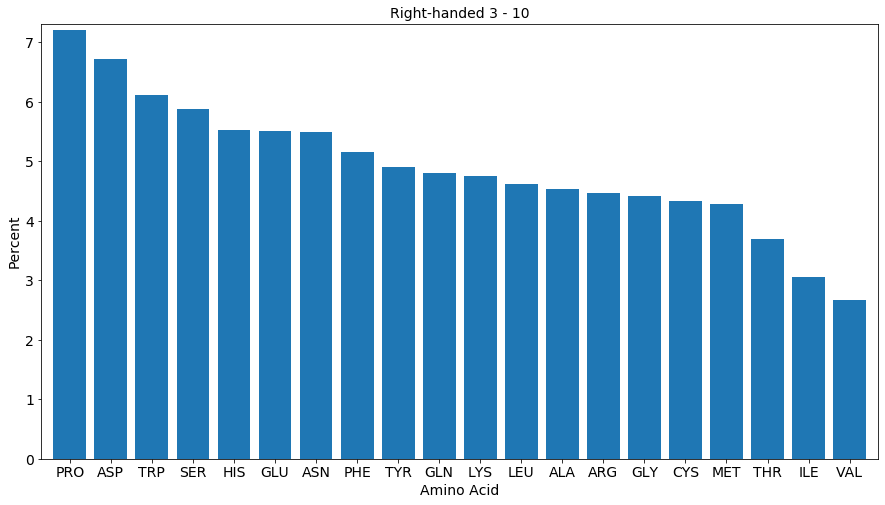

In [21]:
amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

aa_preference = [0] * len(amino_acids)
for i in range(0,len(amino_acids)):
    num = len(helix_atoms[np.where(helix_atoms['resName'] == amino_acids[i])])
    den = len(amino_data[np.where(amino_data['resName'] == amino_acids[i])])
    aa_preference[i] = (amino_acids[i], num, den, num/den)
    

aa_helix_pref = np.array(aa_preference,
                         dtype=[('aa', 'U3'), ('sheetCnt', 'i4'), 
                                ('totalCnt', 'i4'), ('perc', 'f8')])

aa_helix_pref = np.sort(aa_helix_pref,order='perc')
aa_helix_pref = aa_helix_pref[::-1]

ind = np.arange(len(aa_helix_pref))
plt.figure(figsize=(15,8))
plt.bar(ind,aa_helix_pref['perc']*100)
plt.title("Right-handed 3 - 10",fontsize=14)
plt.xticks(ind, aa_helix_pref['aa'],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Amino Acid",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.margins(0.015)
plt.show()

3. Analyze the length of helices (in terms of number of AAs). Is there any relation between the type of a helix and its length?

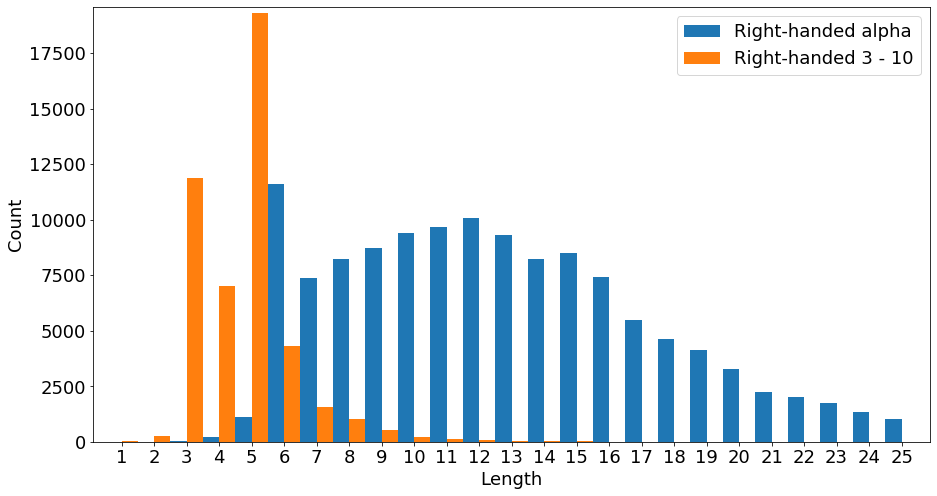

In [75]:
import matplotlib.pyplot as plt

'''
                                     CLASS NUMBER
TYPE OF  HELIX                     (COLUMNS 39 - 40)
--------------------------------------------------------------
Right-handed alpha (default)                1
Right-handed omega                          2
Right-handed pi                             3
Right-handed gamma                          4
Right-handed 3 - 10                         5
Left-handed alpha                           6
Left-handed omega                           7
Left-handed gamma                           8
2 - 7 ribbon/helix                          9
Polyproline                                10
'''

helix_rha = helix_data[np.where(helix_data['helixClass'] == 1)]
helix_rh310 = helix_data[np.where(helix_data['helixClass'] == 5)]

rha_len, rha_counts = np.unique(helix_rha['length'],return_counts=True)
rh310_len, rh310_counts = np.unique(helix_rh310['length'],return_counts=True)


good_data = np.where(rha_len <= 25)
rha_len = rha_len[good_data]
rha_counts = rha_counts[good_data]

good_data = np.where(rh310_len <= 25)
rh310_len = rh310_len[good_data]
rh310_counts = rh310_counts[good_data]

rha_data = [0]*26
rh310_data = [0]*26
lengths = []

for i in range(0,len(rha_len)):
    rha_data[rha_len[i]] = rha_counts[i]
    
for i in range(0,len(rh310_len)):
    rh310_data[rh310_len[i]]= rh310_counts[i]

for i in range(1,26):
    lengths.append(i)

ind = np.arange(len(lengths))
plt.figure(figsize=(15,8))
plt.bar(ind-0.25,rha_data[1:],width=0.5)
plt.bar(ind+0.25,rh310_data[1:],width=0.5)

plt.xticks(ind, lengths)
plt.legend(("Right-handed alpha","Right-handed 3 - 10"),fontsize=18)
plt.xlabel("Length",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.margins(0.015)
plt.show()


4. Analyze the torsion angles in each type of helices. Build something similar to Ramachandran plot but for different types of helices.

In [2]:
import math

def get_torsion_angle(a1, a2, a3, a4):

    atom1 = a1[['x','y','z']][0].tolist()
    atom2 = a2[['x','y','z']][0].tolist()
    atom3 = a3[['x','y','z']][0].tolist()
    atom4 = a4[['x','y','z']][0].tolist()
    
    vector12 = np.subtract(atom2, atom1)
    vector23 = np.subtract(atom3, atom2)
    vector34 = np.subtract(atom4, atom3)

    cross123 = np.cross(vector12,vector23)
    cross234 = np.cross(vector23,vector34)

    cv1 = cross123/np.sqrt(np.dot(cross123,cross123))
    cv2 = cross234/np.sqrt(np.dot(cross234,cross234))

    uv1 = cv2
    uv3 = vector23/(np.sqrt(np.dot(vector23,vector23)))
    uv2 = np.cross(uv3,uv1)

    cos_theta = np.dot(cv1,uv1)
    sin_theta = np.dot(cv1,uv2)

    theta_rad = -math.atan2(sin_theta,cos_theta)
    return np.degrees(theta_rad)


phi_angles_rha = []
psi_angles_rha = []
phi_angles_rh310 = []
psi_angles_rh310 = []

amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
tmp_helix = helix_data[np.logical_or(helix_data['helixClass'] == 1, helix_data['helixClass'] == 5)]

pdbIDC_data = np.unique(tmp_helix['pdbIDC'])
helix_atoms = None
NoneType = type(helix_atoms)

good_rha_atoms = None
good_rh310_atoms = None

for pdbIDC in pdbIDC_data:
    
    # grab all atoms in right hand alpha and right hand 3-10
    tmp_helices = helix_data[np.where(helix_data['pdbIDC'] == pdbIDC)]
    tmp_atoms = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_good_rha = None
    tmp_good_rh310 = None
    for helix in tmp_helices:
        good_atoms = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] >= helix['initSeqNum'],tmp_atoms['resSeq']<=helix['endSeqNum'])]
        if helix['helixClass'] == 1:
            if type(tmp_good_rha) == NoneType:
                tmp_good_rha = good_atoms
            else:
                tmp_good_rha = np.concatenate((tmp_good_rha,good_atoms),axis=0)
        elif helix['helixClass'] == 5:
            if type(tmp_good_rh310) == NoneType:
                tmp_good_rh310 = good_atoms
            else:
                tmp_good_rh310 = np.concatenate((tmp_good_rh310,good_atoms),axis=0)                
    
    # make sure there are no repeats
    if(type(tmp_good_rha) != NoneType):
        tmp, indices = np.unique(tmp_good_rha['resSeq'],return_index=True)
        tmp_good_rha = tmp_good_rha[indices]
        
        if(type(good_rha_atoms) == NoneType):
            good_rha_atoms = tmp_good_rha
        else:
            good_rha_atoms = np.concatenate((good_rha_atoms,tmp_good_rha),axis=0)

        # get phi and psi for each right hand alpha and right hand 3-10
        for resSeq in tmp_good_rha['resSeq']:
            atom1 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq-1, tmp_atoms['name'] == 'C')]
            atom2 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'N')]
            atom3 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'CA')]
            atom4 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'C')]
            atom5 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq+1, tmp_atoms['name'] == 'N')]

            if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
                phi_angles_rha.append(get_torsion_angle(atom1, atom2, atom3, atom4))
                psi_angles_rha.append(get_torsion_angle(atom2, atom3, atom4, atom5))

    if(type(tmp_good_rh310) != NoneType):
        tmp, indices = np.unique(tmp_good_rh310['resSeq'],return_index=True)
        tmp_good_rh310 = tmp_good_rh310[indices]
        
        if(type(good_rh310_atoms) == NoneType):
            good_rh310_atoms = tmp_good_rh310
        else:
            good_rh310_atoms = np.concatenate((good_rh310_atoms,tmp_good_rh310),axis=0)
            
        for resSeq in tmp_good_rh310['resSeq']:
            atom1 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq-1, tmp_atoms['name'] == 'C')]
            atom2 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'N')]
            atom3 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'CA')]
            atom4 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq, tmp_atoms['name'] == 'C')]
            atom5 = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] == resSeq+1, tmp_atoms['name'] == 'N')]

            if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
                phi_angles_rh310.append(get_torsion_angle(atom1, atom2, atom3, atom4))
                psi_angles_rh310.append(get_torsion_angle(atom2, atom3, atom4, atom5))


In [10]:
good_rha_atoms = good_rha_atoms[np.where(good_rha_atoms['name'] == "N")]
rha_aa, rha_counts = np.unique(good_rha_atoms['resName'],return_counts=True)

amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

rha_info = []
for i in range(0,len(rha_aa)):
    if(rha_aa[i] in amino_acids):
        rha_info.append((rha_aa[i],rha_counts[i],100*rha_counts[i]/np.sum(rha_counts)))
    
rha_info = np.array(rha_info,
                      dtype=[('AA', 'U3'), ('AA Count', 'i4'), ('AA Percentage', 'f8')])

df_rha_info = pd.DataFrame(rha_info)
print(len(good_rha_atoms))
df_rha_info.style.hide_index()

1780618


AA,AA Count,AA Percentage
ALA,189809,10.6597
ARG,105389,5.91868
ASN,68625,3.854
ASP,97453,5.47299
CYS,19566,1.09883
GLN,82701,4.64451
GLU,149159,8.37681
GLY,79048,4.43936
HIS,38063,2.13763
ILE,101924,5.72408


In [9]:
good_rh310_atoms = good_rh310_atoms[np.where(good_rh310_atoms['name'] == "N")]
rh310_aa, rh310_counts = np.unique(good_rh310_atoms['resName'],return_counts=True)

amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

rh310_info = []
for i in range(0,len(rh310_aa)):
    if(rh310_aa[i] in amino_acids):
        rh310_info.append((rh310_aa[i],rh310_counts[i],100*rh310_counts[i]/np.sum(rh310_counts)))
    
rh310_info = np.array(rh310_info,
                      dtype=[('AA', 'U3'), ('AA Count', 'i4'), ('AA Percentage', 'f8')])

df_rh310_info = pd.DataFrame(rh310_info)
print(len(good_rh310_atoms))
df_rh310_info.style.hide_index()

216731


AA,AA Count,AA Percentage
ALA,16471,7.59974
ARG,10354,4.77735
ASN,10659,4.91808
ASP,17842,8.23232
CYS,2458,1.13412
GLN,8169,3.76919
GLU,16706,7.70817
GLY,13878,6.40333
HIS,5822,2.68628
ILE,8011,3.69629


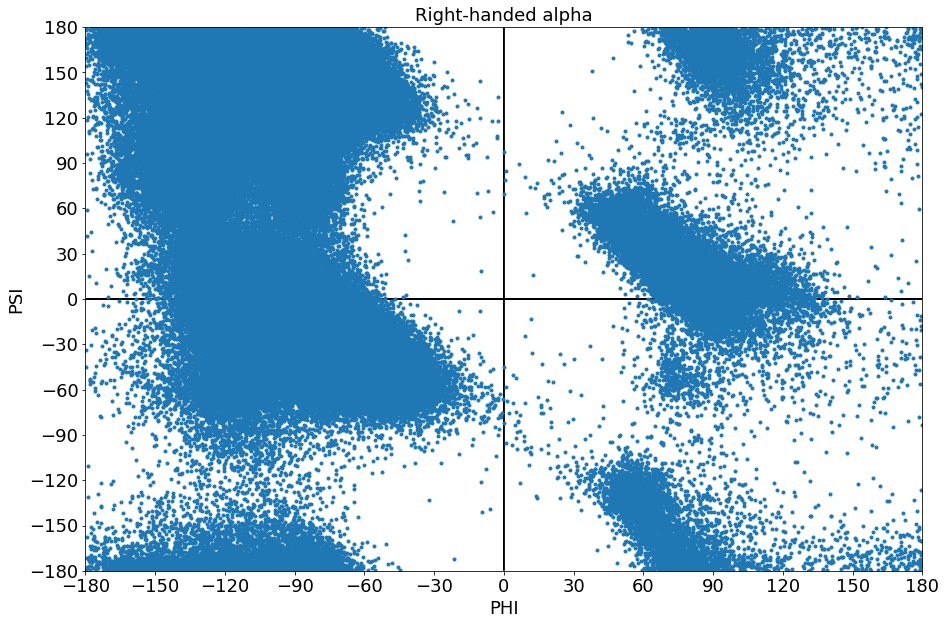

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(phi_angles_rha,psi_angles_rha,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.title("Right-handed alpha",fontsize=18)
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
# Show plot
plt.show()

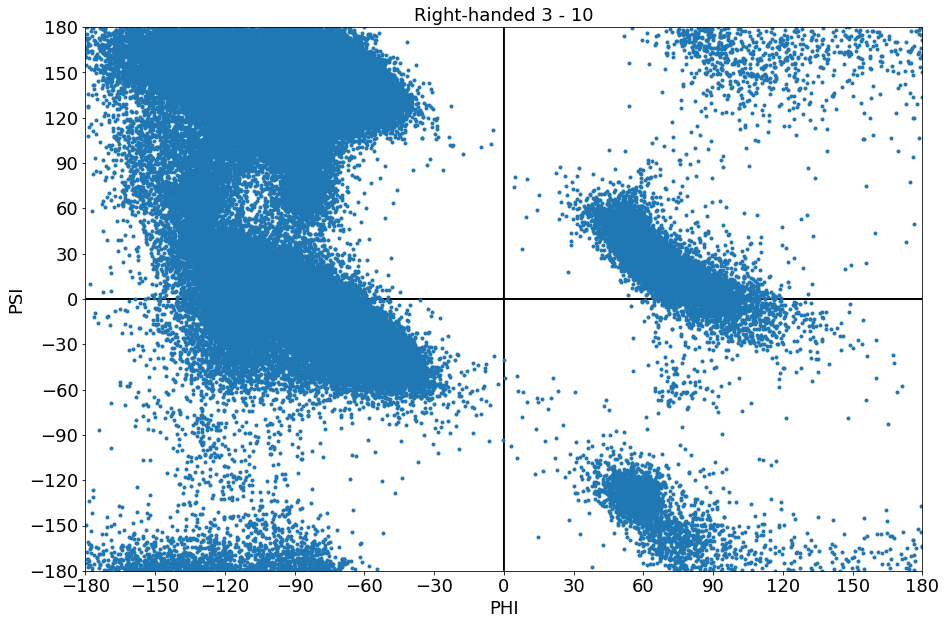

In [80]:
plt.figure(figsize=(15,10))
plt.plot(phi_angles_rh310,psi_angles_rh310,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.title("Right-handed 3 - 10",fontsize=18)
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
# Show plot
plt.show()

5. Analyze the amino acids that prefer to form/be part of beta-sheets. Analyze the number of strands in beta-sheets.

In [20]:
amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = amino_data[np.where(amino_data['name'] == 'N')]

pdbIDC_data = np.unique(sheet_data['pdbIDC'])
sheet_atoms = None
NoneType = type(sheet_atoms)

for pdbIDC in pdbIDC_data:
    tmp_sheets = sheet_data[np.where(sheet_data['pdbIDC'] == pdbIDC)]
    tmp_atoms = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_good_atoms = None
    for sheet in tmp_sheets:
        good_atoms = tmp_atoms[np.logical_and(tmp_atoms['resSeq'] >= sheet['initSeqNum'],tmp_atoms['resSeq']<=sheet['endSeqNum'])]
        if type(tmp_good_atoms) == NoneType:
            tmp_good_atoms = good_atoms
        else:
            tmp_good_atoms = np.concatenate((tmp_good_atoms,good_atoms),axis=0)
            
    tmp, indices = np.unique(tmp_good_atoms['resSeq'],return_index=True)
    tmp_good_atoms = tmp_good_atoms[indices]
    
    if type(sheet_atoms) == NoneType:
        sheet_atoms = tmp_good_atoms
    else:
        sheet_atoms = np.concatenate((sheet_atoms,tmp_good_atoms),axis=0)            
                
    
amino_acids = ['ALA','ARG','ASN','ASP','CYS',
               'GLN','GLU','GLY','HIS','ILE',
               'LEU','LYS','MET','PHE','PRO',
               'SER','THR','TRP','TYR','VAL']

aa_preference = [0] * len(amino_acids)
for i in range(0,len(amino_acids)):
    num = len(sheet_atoms[np.where(sheet_atoms['resName'] == amino_acids[i])])
    den = len(amino_data[np.where(amino_data['resName'] == amino_acids[i])])
    aa_preference[i] = (amino_acids[i], num, den, num/den)


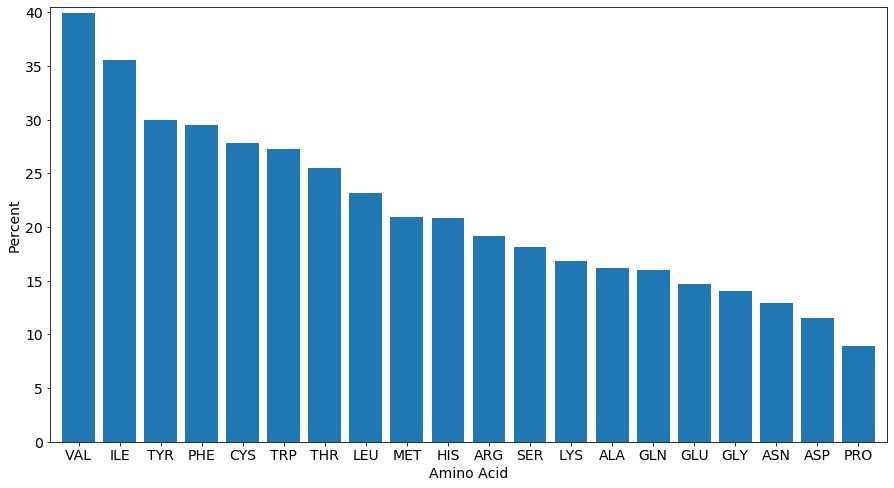

In [21]:
aa_sheet_pref = np.array(aa_preference,
                         dtype=[('aa', 'U3'), ('sheetCnt', 'i4'), 
                                ('totalCnt', 'i4'), ('perc', 'f8')])

aa_sheet_pref = np.sort(aa_sheet_pref,order='perc')
aa_sheet_pref = aa_sheet_pref[::-1]

ind = np.arange(len(aa_sheet_pref))
plt.figure(figsize=(15,8))
plt.bar(ind,aa_sheet_pref['perc']*100)
plt.xticks(ind, aa_sheet_pref['aa'],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Amino Acid",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.margins(0.015)
plt.show()

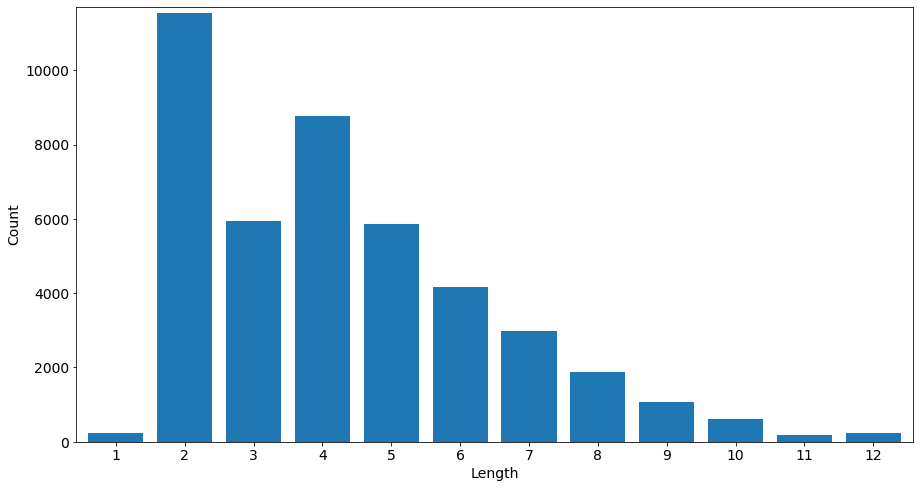

In [22]:
sheet_tmp = sheet_data[np.where(sheet_data['strand'] == 1)]
sheet_sizes,size_counts = np.unique(sheet_tmp['numStrands'], return_counts=True)

lower = np.mean(size_counts)*.10
good_data = np.where(size_counts >= lower)
sheet_sizes = sheet_sizes[good_data]
size_counts = size_counts[good_data]

ind = np.arange(len(sheet_sizes))
plt.figure(figsize=(15,8))
plt.bar(ind,size_counts)
plt.xticks(ind, sheet_sizes,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Length",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.margins(0.015)
plt.show()

6. Build Ramachandran plot for a given AA?

In [23]:
import math

def get_torsion_angle(a1, a2, a3, a4):

    atom1 = a1[['x','y','z']][0].tolist()
    atom2 = a2[['x','y','z']][0].tolist()
    atom3 = a3[['x','y','z']][0].tolist()
    atom4 = a4[['x','y','z']][0].tolist()
    
    vector12 = np.subtract(atom2, atom1)
    vector23 = np.subtract(atom3, atom2)
    vector34 = np.subtract(atom4, atom3)

    cross123 = np.cross(vector12,vector23)
    cross234 = np.cross(vector23,vector34)

    cv1 = cross123/np.sqrt(np.dot(cross123,cross123))
    cv2 = cross234/np.sqrt(np.dot(cross234,cross234))

    uv1 = cv2
    uv3 = vector23/(np.sqrt(np.dot(vector23,vector23)))
    uv2 = np.cross(uv3,uv1)

    cos_theta = np.dot(cv1,uv1)
    sin_theta = np.dot(cv1,uv2)

    theta_rad = -math.atan2(sin_theta,cos_theta)
    return np.degrees(theta_rad)


aa = "GLU"

phi_angles = []
psi_angles = []

tmp_amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = tmp_amino_data[np.logical_and(tmp_amino_data['resName'] == aa, tmp_amino_data['name'] == 'N')]
pdbIDC_data = np.unique(amino_data['pdbIDC'])

for pdbIDC in pdbIDC_data:
    tmp_rseq_data = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_atom_data = tmp_amino_data[np.where(tmp_amino_data['pdbIDC'] == pdbIDC)]
    
    for resSeq in tmp_rseq_data['resSeq']:
        atom1 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq-1, tmp_atom_data['name'] == 'C')]
        atom2 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'N')]
        atom3 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'CA')]
        atom4 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'C')]
        atom5 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq+1, tmp_atom_data['name'] == 'N')]
        
        if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
            phi_angles.append(get_torsion_angle(atom1, atom2, atom3, atom4))
            psi_angles.append(get_torsion_angle(atom2, atom3, atom4, atom5))


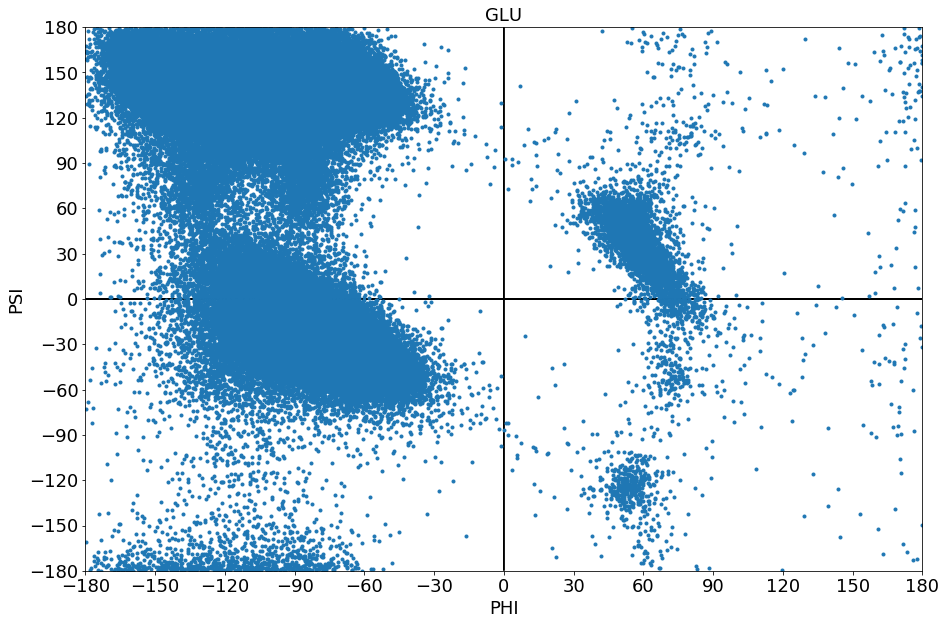

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(phi_angles,psi_angles,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
plt.title(aa,fontsize=18)
# Show plot
plt.show()

In [25]:
import math

def get_torsion_angle(a1, a2, a3, a4):

    atom1 = a1[['x','y','z']][0].tolist()
    atom2 = a2[['x','y','z']][0].tolist()
    atom3 = a3[['x','y','z']][0].tolist()
    atom4 = a4[['x','y','z']][0].tolist()
    
    vector12 = np.subtract(atom2, atom1)
    vector23 = np.subtract(atom3, atom2)
    vector34 = np.subtract(atom4, atom3)

    cross123 = np.cross(vector12,vector23)
    cross234 = np.cross(vector23,vector34)

    cv1 = cross123/np.sqrt(np.dot(cross123,cross123))
    cv2 = cross234/np.sqrt(np.dot(cross234,cross234))

    uv1 = cv2
    uv3 = vector23/(np.sqrt(np.dot(vector23,vector23)))
    uv2 = np.cross(uv3,uv1)

    cos_theta = np.dot(cv1,uv1)
    sin_theta = np.dot(cv1,uv2)

    theta_rad = -math.atan2(sin_theta,cos_theta)
    return np.degrees(theta_rad)


aa = "ALA"

phi_angles = []
psi_angles = []

tmp_amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = tmp_amino_data[np.logical_and(tmp_amino_data['resName'] == aa, tmp_amino_data['name'] == 'N')]
pdbIDC_data = np.unique(amino_data['pdbIDC'])

for pdbIDC in pdbIDC_data:
    tmp_rseq_data = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_atom_data = tmp_amino_data[np.where(tmp_amino_data['pdbIDC'] == pdbIDC)]
    
    for resSeq in tmp_rseq_data['resSeq']:
        atom1 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq-1, tmp_atom_data['name'] == 'C')]
        atom2 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'N')]
        atom3 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'CA')]
        atom4 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'C')]
        atom5 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq+1, tmp_atom_data['name'] == 'N')]
        
        if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
            phi_angles.append(get_torsion_angle(atom1, atom2, atom3, atom4))
            psi_angles.append(get_torsion_angle(atom2, atom3, atom4, atom5))


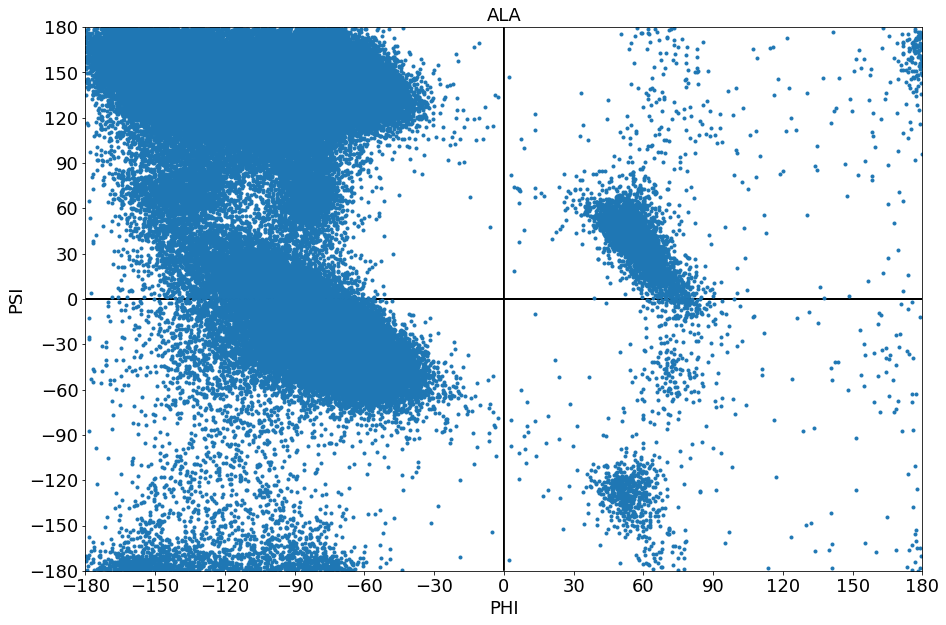

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(phi_angles,psi_angles,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
plt.title(aa,fontsize=18)
# Show plot
plt.show()

In [27]:
import math

def get_torsion_angle(a1, a2, a3, a4):

    atom1 = a1[['x','y','z']][0].tolist()
    atom2 = a2[['x','y','z']][0].tolist()
    atom3 = a3[['x','y','z']][0].tolist()
    atom4 = a4[['x','y','z']][0].tolist()
    
    vector12 = np.subtract(atom2, atom1)
    vector23 = np.subtract(atom3, atom2)
    vector34 = np.subtract(atom4, atom3)

    cross123 = np.cross(vector12,vector23)
    cross234 = np.cross(vector23,vector34)

    cv1 = cross123/np.sqrt(np.dot(cross123,cross123))
    cv2 = cross234/np.sqrt(np.dot(cross234,cross234))

    uv1 = cv2
    uv3 = vector23/(np.sqrt(np.dot(vector23,vector23)))
    uv2 = np.cross(uv3,uv1)

    cos_theta = np.dot(cv1,uv1)
    sin_theta = np.dot(cv1,uv2)

    theta_rad = -math.atan2(sin_theta,cos_theta)
    return np.degrees(theta_rad)


aa = "VAL"

phi_angles = []
psi_angles = []

tmp_amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = tmp_amino_data[np.logical_and(tmp_amino_data['resName'] == aa, tmp_amino_data['name'] == 'N')]
pdbIDC_data = np.unique(amino_data['pdbIDC'])

for pdbIDC in pdbIDC_data:
    tmp_rseq_data = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_atom_data = tmp_amino_data[np.where(tmp_amino_data['pdbIDC'] == pdbIDC)]
    
    for resSeq in tmp_rseq_data['resSeq']:
        atom1 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq-1, tmp_atom_data['name'] == 'C')]
        atom2 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'N')]
        atom3 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'CA')]
        atom4 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'C')]
        atom5 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq+1, tmp_atom_data['name'] == 'N')]
        
        if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
            phi_angles.append(get_torsion_angle(atom1, atom2, atom3, atom4))
            psi_angles.append(get_torsion_angle(atom2, atom3, atom4, atom5))


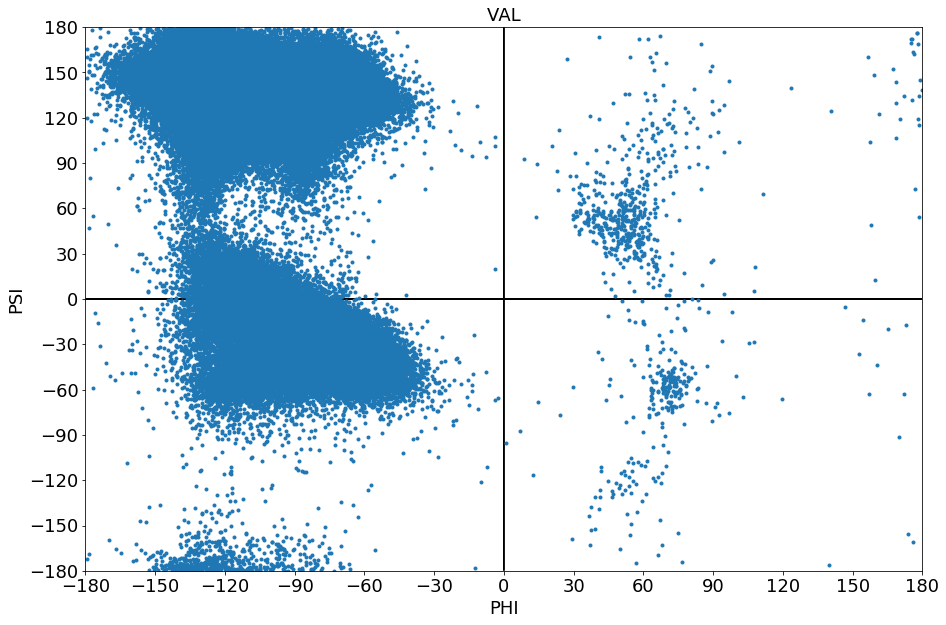

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(phi_angles,psi_angles,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
plt.title(aa,fontsize=18)
# Show plot
plt.show()

In [29]:
import math

def get_torsion_angle(a1, a2, a3, a4):

    atom1 = a1[['x','y','z']][0].tolist()
    atom2 = a2[['x','y','z']][0].tolist()
    atom3 = a3[['x','y','z']][0].tolist()
    atom4 = a4[['x','y','z']][0].tolist()
    
    vector12 = np.subtract(atom2, atom1)
    vector23 = np.subtract(atom3, atom2)
    vector34 = np.subtract(atom4, atom3)

    cross123 = np.cross(vector12,vector23)
    cross234 = np.cross(vector23,vector34)

    cv1 = cross123/np.sqrt(np.dot(cross123,cross123))
    cv2 = cross234/np.sqrt(np.dot(cross234,cross234))

    uv1 = cv2
    uv3 = vector23/(np.sqrt(np.dot(vector23,vector23)))
    uv2 = np.cross(uv3,uv1)

    cos_theta = np.dot(cv1,uv1)
    sin_theta = np.dot(cv1,uv2)

    theta_rad = -math.atan2(sin_theta,cos_theta)
    return np.degrees(theta_rad)


aa = "ILE"

phi_angles = []
psi_angles = []

tmp_amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
amino_data = tmp_amino_data[np.logical_and(tmp_amino_data['resName'] == aa, tmp_amino_data['name'] == 'N')]
pdbIDC_data = np.unique(amino_data['pdbIDC'])

for pdbIDC in pdbIDC_data:
    tmp_rseq_data = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_atom_data = tmp_amino_data[np.where(tmp_amino_data['pdbIDC'] == pdbIDC)]
    
    for resSeq in tmp_rseq_data['resSeq']:
        atom1 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq-1, tmp_atom_data['name'] == 'C')]
        atom2 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'N')]
        atom3 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'CA')]
        atom4 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq, tmp_atom_data['name'] == 'C')]
        atom5 = tmp_atom_data[np.logical_and(tmp_atom_data['resSeq'] == resSeq+1, tmp_atom_data['name'] == 'N')]
        
        if len(atom1) == 1 and len(atom2) == 1 and len(atom3) == 1 and len(atom4) == 1 and len(atom5) == 1:
            phi_angles.append(get_torsion_angle(atom1, atom2, atom3, atom4))
            psi_angles.append(get_torsion_angle(atom2, atom3, atom4, atom5))


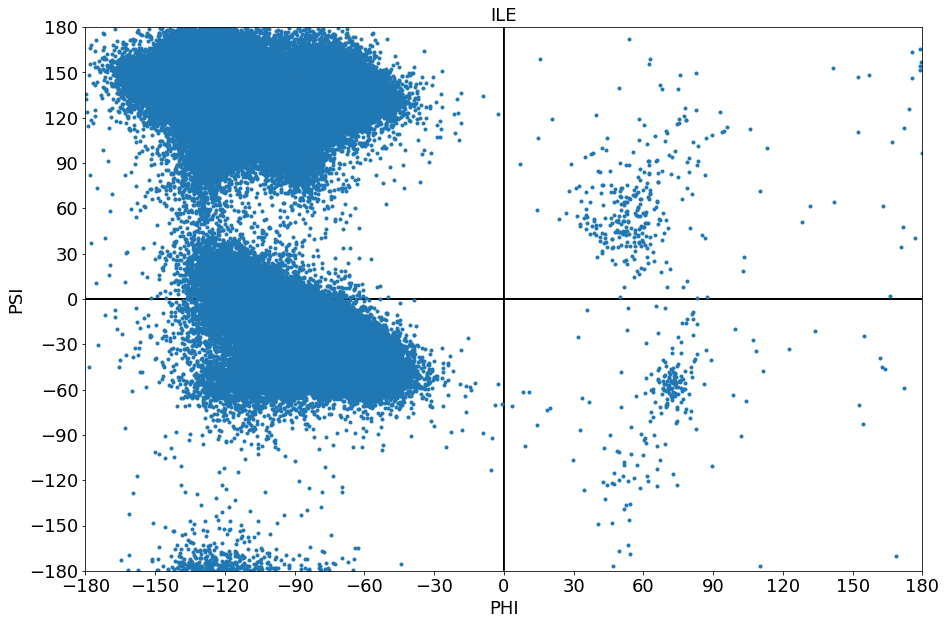

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(phi_angles,psi_angles,".")
plt.xlim(-180,180) # Sets axis limits
plt.ylim(-180,180) # Sets axis limits
plt.xticks(np.arange(-180,181,30),fontsize=18)
plt.yticks(np.arange(-180,181,30),fontsize=18)
plt.xlabel("PHI",fontsize=18)
plt.ylabel("PSI",fontsize=18)
plt.arrow(-180,0,360,0)
plt.arrow(0,-180,0,360)
plt.title(aa,fontsize=18)
# Show plot
plt.show()

7. Analyze the length of bonds and the angle between different type of backbone atoms in general and for individual AAs.

In [3]:
import math
def get_angle(n_coord, ca_coord, c_coord):
    
    nca_coord = [n_coord[0]-ca_coord[0],n_coord[1]-ca_coord[1],n_coord[2]-ca_coord[2]]
    cca_coord = [c_coord[0]-ca_coord[0],c_coord[1]-ca_coord[1],c_coord[2]-ca_coord[2]]

    nca_v = (nca_coord[0]**2+nca_coord[1]**2+nca_coord[2]**2)**.5
    cca_v = (cca_coord[0]**2+cca_coord[1]**2+cca_coord[2]**2)**.5

    nca_n = [nca_coord[0]/nca_v, nca_coord[1]/nca_v, nca_coord[2]/nca_v]
    cca_n = [cca_coord[0]/cca_v, cca_coord[1]/cca_v, cca_coord[2]/cca_v]

    result = nca_n[0]*cca_n[0]+nca_n[1]*cca_n[1]+nca_n[2]*cca_n[2]
    result = math.acos(result)*180.0/math.pi
    return result
    
def get_distance(atom1_coord, atom2_coord):
    distance = ((atom2_coord[0]-atom1_coord[0])**2+(atom2_coord[1]-atom1_coord[1])**2+(atom2_coord[2]-atom1_coord[2])**2)**.5
    return distance
    
amino_data = atom_data[np.logical_or(atom_data['altLoc'] == ' ', atom_data['altLoc'] == 'A')]
pdbIDC_data = np.unique(amino_data['pdbIDC'])

dist_angle_set = []

for pdbIDC in pdbIDC_data:
    tmp_atom_data = amino_data[np.where(amino_data['pdbIDC'] == pdbIDC)]
    tmp_resSeq = np.unique(tmp_atom_data['resSeq'])
    for resSeq in tmp_resSeq:
        tmp_atoms = tmp_atom_data[np.where(tmp_atom_data['resSeq'] == resSeq)]
        if(len(tmp_atoms) == 3):
            aa = tmp_atoms[0]['resName']
            tmp_atoms = tmp_atoms[['x','y','z']]
            angle = get_angle(tmp_atoms[0].tolist(),tmp_atoms[1].tolist(),tmp_atoms[2].tolist())
            ncad = get_distance(tmp_atoms[0].tolist(), tmp_atoms[1].tolist())
            cacd = get_distance(tmp_atoms[1].tolist(), tmp_atoms[2].tolist())
            dist_angle_set.append([aa, angle, ncad, cacd])


In [4]:
dist_angle_set[:10]

[['ALA', 110.50258141003388, 1.4949357845740432, 1.5256952513526427],
 ['TYR', 112.30490475584277, 1.4623631559910142, 1.5301849561409246],
 ['ILE', 110.93015425616395, 1.4621357666099277, 1.5298241729035378],
 ['ALA', 112.03494494067337, 1.4631288391662558, 1.5240114828963716],
 ['LYS', 114.47814523201531, 1.4614540704380663, 1.5276184078492911],
 ['GLN', 111.32673193706519, 1.4666332193155842, 1.5163037294684698],
 ['ARG', 111.22981675287453, 1.4478135239042342, 1.5234861338390955],
 ['GLN', 112.12137859217172, 1.4555473197392113, 1.5261038627826058],
 ['ILE', 112.11948952387284, 1.467065438213308, 1.5306423488196061],
 ['SER', 114.82254513476774, 1.4627515168339427, 1.5390717981952615]]

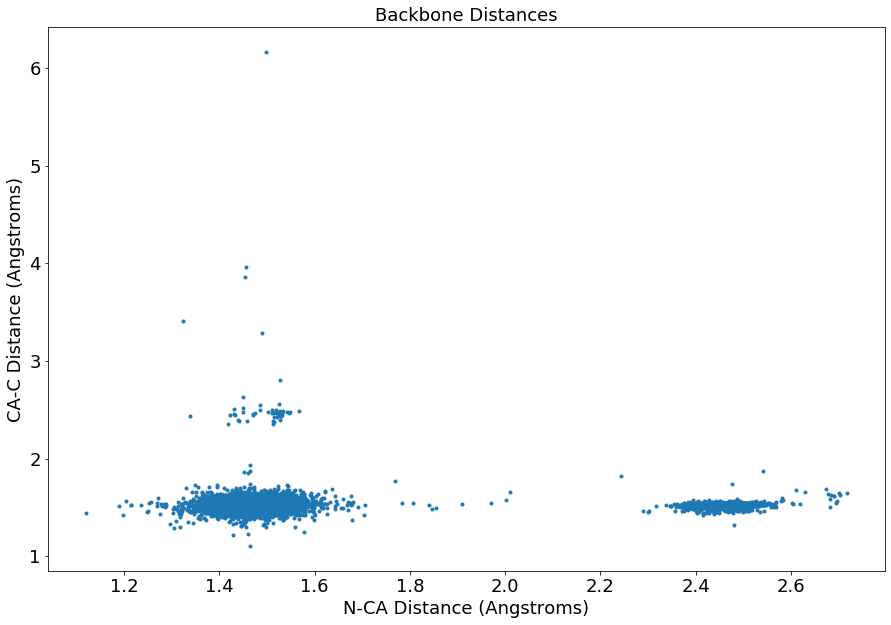

In [19]:
for i in range(0,len(dist_angle_set)):
    dist_angle_set[i] = tuple(dist_angle_set[i])
dist_angle_arr = np.array(dist_angle_set,
                          dtype=[('aa', 'U3'), ('angle', 'f8'),
                                 ('n_to_ca', 'f8'), ('ca_to_c', 'f8')])

plt.figure(figsize=(15,10))
plt.plot(dist_angle_arr['n_to_ca'],dist_angle_arr['ca_to_c'],".")
plt.title("Backbone Distances",fontsize=18)
plt.xlabel("N-CA Distance (Angstroms)",fontsize=18)
plt.ylabel("CA-C Distance (Angstroms)",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

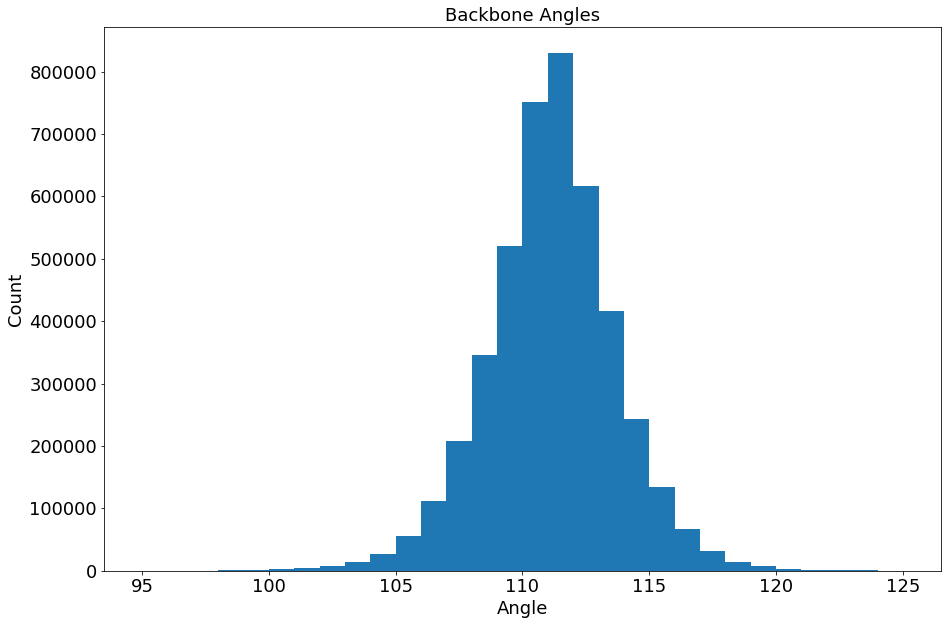

In [18]:
plt.figure(figsize=(15,10))
plt.hist(dist_angle_arr['angle'],30,range=[95,125])
plt.title("Backbone Angles",fontsize=18)
plt.xlabel("Angle",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()